In [1]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from fbprophet.diagnostics import cross_validation, performance_metrics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from covid19prophet.fbprophet import fit_model, cross_validate, tune_hyperparameters, make_forecasts # my own module
from covid19prophet.sarima import walk_forward_validation # my own module

# Data Prep

In [2]:
# load data
# os.chdir('/Users/yupinghe/Documents/Futuristic/covid19prophet')
# df = pd.read_csv('covid19prophet/time_series_covid19_confirmed_US.csv')

# John Hopkins data upate
# county-level confirmed cases
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
df = pd.read_csv(url)

print(f'Dataset size: ', {df.shape}, '\n') 
print(df.iloc[:,-5:].head())

Dataset size:  {(3261, 144)} 

   5/29/20  5/30/20  5/31/20  6/1/20  6/2/20
0        0        0        0       0       0
1      172      172      172     175     175
2       22       22       22      22      23
3     3647     3718     3776    3873    3935
4       69       69       69      70      70


In [3]:
# wide to long
df_ny = df.loc[df['Province_State']=='New York', df.columns[11:].to_list()].melt(
    id_vars=None, 
    value_vars=df.columns[11:].to_list(),
    var_name='Date', 
    value_name='Cases')

df_ny['Date'] = pd.to_datetime(df_ny['Date'])

# Set to time series
ts_ny = df_ny.set_index(df_ny['Date']).loc[:,['Cases']].resample('D').sum()

# Calcualte daily new cases
ts_ny['Cases_lag1'] = ts_ny.shift(1)
ts_ny['Cases_new'] = ts_ny['Cases'] - ts_ny['Cases_lag1']


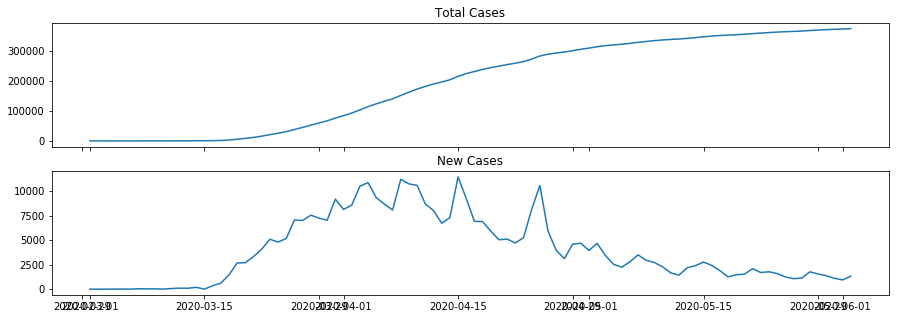

In [4]:

fig, ax = plt.subplots(2, 1, sharey=False, sharex=True, figsize=(15, 5))

ax[0].plot(ts_ny['2020-03-01':].index, ts_ny.loc['2020-03-01':,['Cases']], label='Total')
ax[1].plot(ts_ny['2020-03-01':].index, ts_ny.loc['2020-03-01':,['Cases_new']])

ax[0].title.set_text('Total Cases')
ax[1].title.set_text('New Cases')

plt.show()


In [5]:
ts_ny_train = ts_ny.loc['2020-03-02':,['Cases_new']]
# .reset_index().rename(columns={'Date':'ds', 'Cases_new':'y'})
# ts_ny_train.tail(10)
ts_ny_train.tail(10)

,Cases_new
Date,
2020-05-24,1589.0
2020-05-25,1249.0
2020-05-26,1072.0
2020-05-27,1129.0
2020-05-28,1768.0
2020-05-29,1551.0
2020-05-30,1376.0
2020-05-31,1110.0
2020-06-01,941.0


# SARIMA

In [6]:
# initial test
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(ts_ny_train)
print(f'Test Statistic: {np.round(adf,2)}, P-value: {np.round(pvalue,2)}')

Test Statistic: -2.36, P-value: 0.15


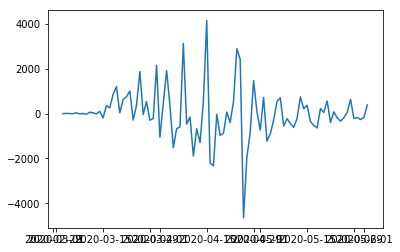

In [7]:
# detrend: Subtract the rolling mean
ts_ny_train2 = ts_ny_train.diff().dropna()
# ts_ny_train2 = np.log(ts_ny_train).diff().dropna()
plt.plot(ts_ny_train2)
plt.show()

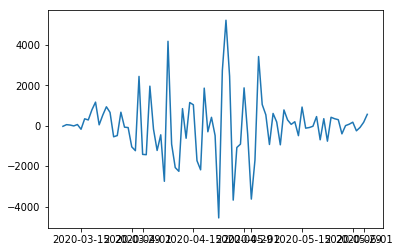

In [9]:
# Take the first and seasonal differences and drop NaNs ??? why differencing?? --> stationary
ts_ny_train3 = ts_ny_train.diff().diff(7).dropna()
plt.plot(ts_ny_train3)
plt.show()

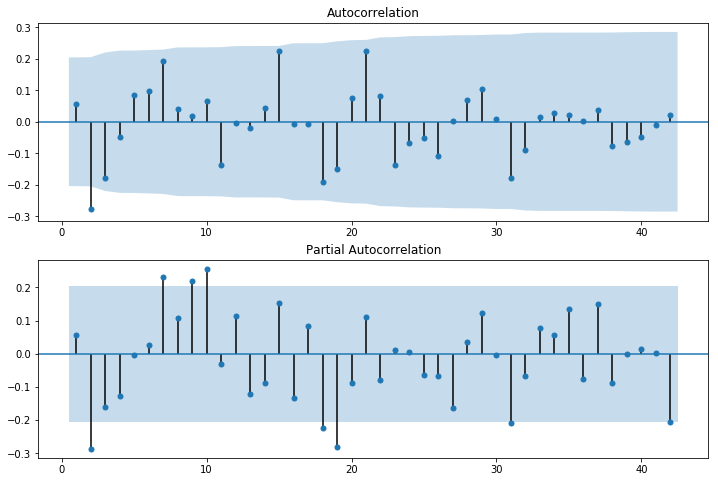

In [8]:
# ACF, PACF

# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
# Plot ACF and PACF
plot_acf(ts_ny_train2, lags=42, zero=False, ax=ax1)
plot_pacf(ts_ny_train2, lags=42, zero=False, ax=ax2)
# Show plot
plt.show()

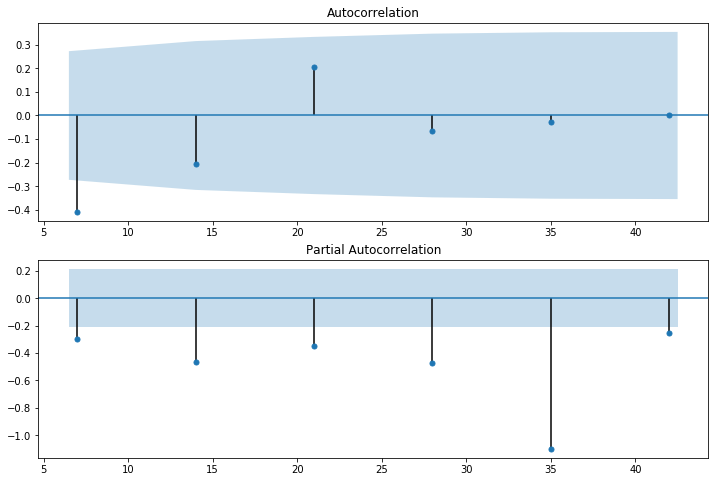

In [10]:

lags = [7, 14, 21, 28, 35, 42]
# Create the figure 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,8))
# Plot the ACF on ax1
plot_acf(ts_ny_train3, lags=lags, ax=ax1)
# Plot the PACF on ax2
plot_pacf(ts_ny_train3, lags=lags, ax=ax2)
plt.show()


In [12]:
#set parameter range
p = range(0,3)
q = range(0,3)
d = range(1,2)
P = range(0,2)
Q = range(0,2)
D = range(1,2)
s = range(7,8)

params = walk_forward_validation(p,q,d,P,Q,D,s, freq=14, training_range=21, forecast_horizon=7, data=ts_ny_train)

Optimization terminated successfully.
         Current function value: 4.611920
         Iterations: 3
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: 5.127539
         Iterations: 6
         Function evaluations: 291
Optimization terminated successfully.
         Current function value: 5.567229
         Iterations: 3
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: 5.609297
         Iterations: 8
         Function evaluations: 385
Optimization terminated successfully.
         Current function value: 4.636887
         Iterations: 3
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 4.608950
         Iterations: 3
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: 5.129877
         Iterations: 3
         Function evaluations: 115
Optimization terminated successful

In [38]:
# Make forecasts
mape_lowest = params['mape'].min()

sarima_final = SARIMAX(
    ts_ny_train, 
    order = (
        params.loc[params['mape']==mape_lowest,'p'].item(),
        params.loc[params['mape']==mape_lowest,'d'].item(),
        params.loc[params['mape']==mape_lowest,'q'].item()), 
    seasonal_order = (
        params.loc[params['mape']==mape_lowest,'P'].item(),
        params.loc[params['mape']==mape_lowest,'D'].item(),
        params.loc[params['mape']==mape_lowest,'Q'].item(),
        params.loc[params['mape']==mape_lowest,'s'].item()))

sarima_results = sarima_final.fit(max_iter = 50, method = 'powell')
# Dynamic forecasts: forecast on top of forecast when no actual data available
pred = sarima_results.get_prediction(start=len(ts_ny_train), end=len(ts_ny_train)+7, dynamic=False)
# In-sample forecasts
pred_insample = sarima_results.get_prediction()

# Get confidence intervals of predictions
pred_ci = pred.conf_int()
pred_insample_ci = pred_insample.conf_int()

# Select lower and upper confidence limits
lower_limits = pred_insample_ci.loc[:,'lower Cases_new']
upper_limits = pred_insample_ci.loc[:,'upper Cases_new']

Optimization terminated successfully.
         Current function value: 7.977172
         Iterations: 1
         Function evaluations: 25


In [ ]:
# Create the 4 diagostics plots
results.plot_diagnostics()
plt.show()

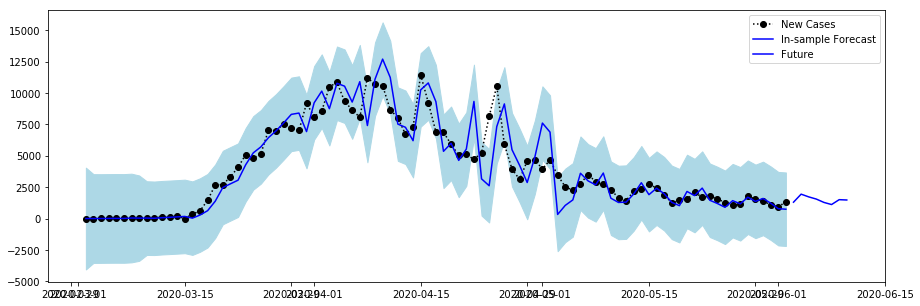

In [44]:
# plot
fig, ax = plt.subplots(figsize=(15, 5))
# plot observed values
ax.plot(ts_ny_train.index, ts_ny_train['Cases_new'], color='black', marker='o', linestyle=':', label='New Cases')
# plot your mean predictions
ax.plot(pred_insample.predicted_mean.index, pred_insample.predicted_mean, color='blue', label='In-sample Forecast')
ax.plot(pred.predicted_mean.index, pred.predicted_mean, color='blue', label='Future')
# shade the area between your confidence limits
ax.fill_between(lower_limits.index, lower_limits, upper_limits, color='lightblue')
plt.legend()
plt.show()


# Prophet

In [45]:
# Propeht format
ts_ny_train = ts_ny.loc['2020-03-02':,['Cases_new']].reset_index().rename(columns={'Date':'ds', 'Cases_new':'y'})
ts_ny_train.tail()

,ds,y
88,2020-05-29,1551.0
89,2020-05-30,1376.0
90,2020-05-31,1110.0
91,2020-06-01,941.0
92,2020-06-02,1329.0


In [46]:
# Hyperparameter tuning
my_grid = {
    'growth': ['logistic', 'linear']
    ,'changepoint_prior': [0.5]
    ,'changepoint_range': [0.8]
    ,'weekly_fourier_order': [3]
    ,'seasonal_mode': ['multiplicative', 'additive']
}

params_best = tune_hyperparameters(data=ts_ny_train, model_prophet=fit_model, model_cv=cross_validate, grid=my_grid)
params_best = params_best.sort_values('MAPE')
mape_lowest = np.min(params_best['MAPE'])
params_best

INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-03-24 00:00:00 and 2020-05-26 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 17.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.
INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-03-24 00:00:00 and 2020-05-26 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 17.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.
INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-03-24 00:00:00 and 2020-05-26 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 17.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.
INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-03-24 00:00:00 and 2020-05-26 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 17.
INFO:fbprophet:n_changepoints greater than number of observations.Us

,growth,changepoint_prior,changepoint_range,weekly_fourier_order,seasonal_mode,MAPE
3,linear,0.5,0.8,3,additive,0.297129
1,logistic,0.5,0.8,3,additive,0.301769
2,linear,0.5,0.8,3,multiplicative,0.305035
0,logistic,0.5,0.8,3,multiplicative,0.326753


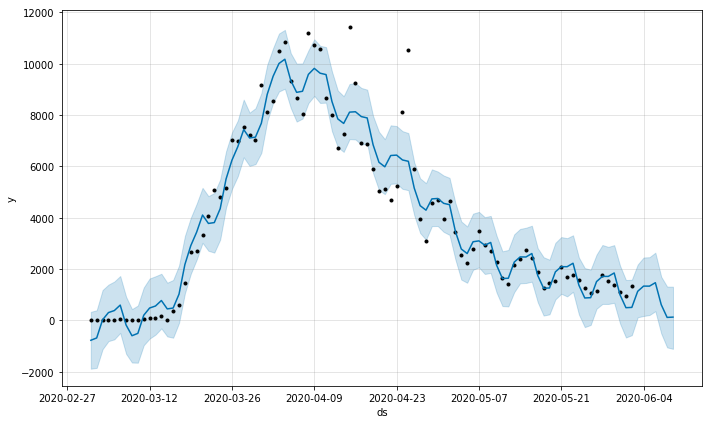

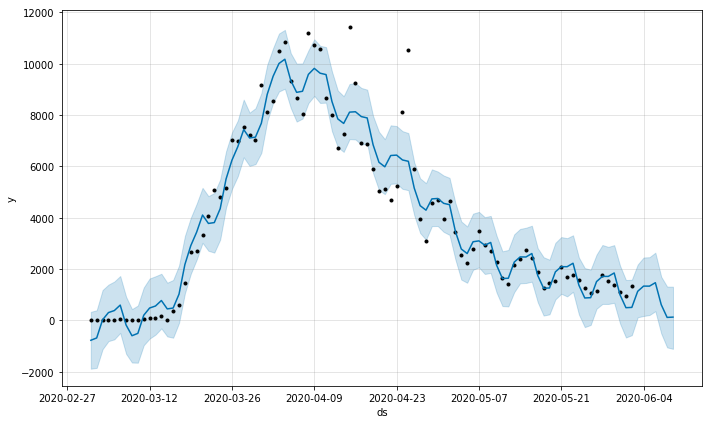

In [47]:
# Generate forecasts for next 7 days
m, forecast = make_forecasts(
        model_prophet=fit_model, 
        ts=ts_ny_train, 
        horizon=7,
        best_trend_func=params_best.loc[params_best['MAPE']==mape_lowest,'growth'].item(), 
        best_changepoint_prior=params_best.loc[params_best['MAPE']==mape_lowest,'changepoint_prior'].item(), 
        best_changepoint_range=params_best.loc[params_best['MAPE']==mape_lowest,'changepoint_range'].item(),
        best_weekly_fourier_order=params_best.loc[params_best['MAPE']==mape_lowest,'weekly_fourier_order'].item(), 
        best_seasonal_mode = params_best.loc[params_best['MAPE']==mape_lowest,'seasonal_mode'].item())

m.plot(forecast)

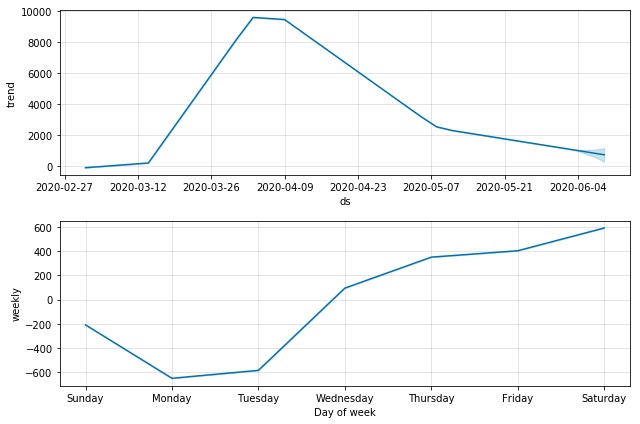

In [48]:
fig = m.plot_components(forecast)

plt.show()

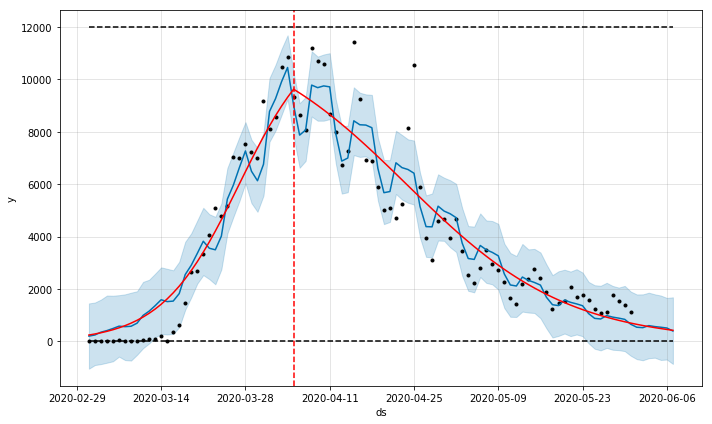

In [127]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

# EDA

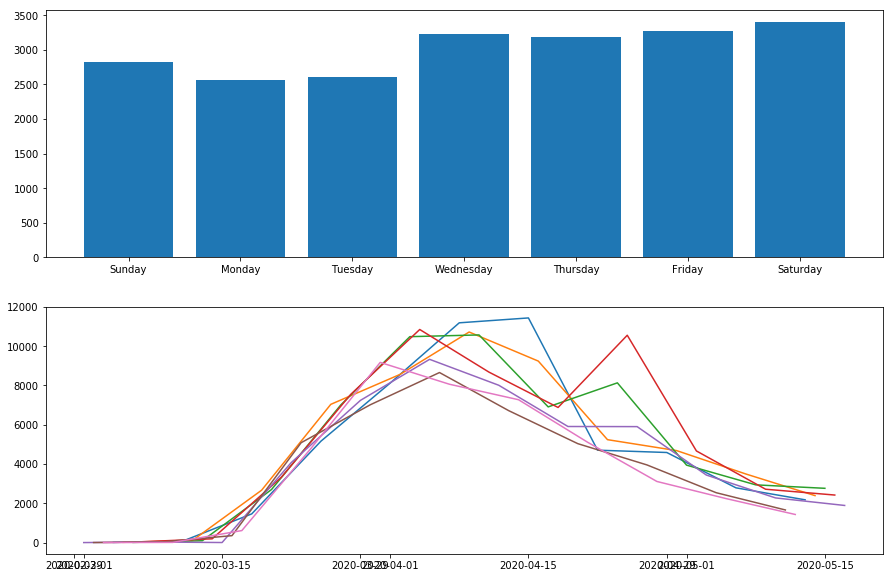

In [126]:
# data for line chart
ts_temp = ts_ny.reset_index()
ts_temp['Weekday'] = ts_temp['Date'].dt.day_name()
ts_temp = ts_temp.set_index('Date')
# data for bar chart
df_temp = ts_temp.groupby(['Weekday'])['Cases_new'].mean()
df_temp = df_temp.reindex(index = ['Sunday', 'Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']).reset_index()

# weekly bar chart: total vs new cases
fig, ax = plt.subplots(2, 1, sharey=False, sharex=False, figsize = [15,10])

for day in ts_temp['Weekday'].unique():
    ax[1].plot(ts_temp.loc['2020-03-01':,].loc[ts_temp['Weekday']==day,:].index, 
        ts_temp.loc['2020-03-01':,['Cases_new']].loc[ts_temp['Weekday']==day,:])

ax[0].bar(df_temp['Weekday'], df_temp['Cases_new'])

plt.show()

# Production/Application
## Ingest new daily cases
## Update Model Performance